<h2>On Call/Put Implied Volatilty Correlation</h2>

<h3>Introduction to Put-Call Parity</h3>

The implied volatility (IV) of a call and a put option should be identical under no-arbitrage conditions (at the same strike price and same expiration). This comes from something called the <b>put-call parity</b> options theorem.

$$C-P = S - Ke^{-rT}$$

where,

C = Call price

P = Put price

S = Stock price

K = Strike price

r = risk-free interest rate

T = time to expiration

We can derive this relation from the Black-Scholes equations, which have underlying assumptions of their own (e.g., assumed normal distribution). The Black-Scholes pricing formulas for a European call and put are:

\begin{align*}
C &= S \Phi(d_1) - K e^{-r(T-t)} \Phi(d_2)\\
P &= K e^{-r(T-t)} \Phi(-d_2) - S \Phi(-d_1)
\end{align*}

Where $\Phi$ is the cumulative distribution function (CDF) of standard normal and,

\begin{align*}
d_1 &= \frac{\ln(S/K) + (r + \sigma^2/2)(T-t)}{\sigma \sqrt{T-t}}\\ \quad d_2 &= d_1 - \sigma \sqrt{T-t}
\end{align*}

Subtracting the put price from the call price:

\begin{align*}
C - P &= \left( S \Phi(d_1) - K e^{-r(T-t)} \Phi(d_2) \right) - \left( K e^{-r(T-t)} \Phi(-d_2) - S \Phi(-d_1) \right) \\
&= S \left( \Phi(d_1) + \Phi(-d_1) \right) - K e^{-r(T-t)} \left( \Phi(d_2) + \Phi(-d_2) \right)
\end{align*}

Since $\Phi(d) + \Phi(-d) = 1$ we get:

\begin{align*}
C - P &= S - K e^{-r(T-t)}
\end{align*}

Which satisfies the put-call parity exactly. If the implied volatilities $\sigma_C$ and $\sigma_P$ for call and put are $\textbf{not equal}$, then the values of $d_1$ and $d_2$ used in each option's pricing formula would differ, which would lead to an arbitrage event.

But in reality, options markets aren't perfectly efficient. Correlation <1.0 exist for a variety of reasons including, 

<ol>
<li> Bid/ask spreads: options markets aren't perfectly efficient.\\

<li> Dividends: affects call/put values slightly differently.\\

<li> Market Imbalance: if more people are buying puts for protection, IV for puts might be slightly higher.\\

<li> Microstructure Noise: short-term supply and demand at different strikes/expirations.\\

<li> Regime Changes: during market crashes, people rush for puts → put IV can spike slightly more than call IV.
</ol>

Focusing on the bid/ask spread issue. This is an interesting one that gets to the heart of options pricing. The Implied Volatility (IV) of an option is a reflection of current market conditions. In other words, we can solve for IV based on the last price or a midpoint between the bid/ask. In fact, the latter is typcially how the IV is generally posted. However, we can be a bit more sophisticated by posting a bidIV and an askIV, but again, according to put-call parity, the bidIV for a call should equal the bidIV for a put (same strike and expiration). However, we can get even more sophisticated by taking into account the change in volatility across the options chain (e.g., volatility skew, volatility smile). Going one step further, we can look at this change across different expiration dates, modeling a volatility surface. Given the discrete steps in the strike price coupled with the discrete time steps in expiry, one could look for arbitrage events by comparing volatility surfaces. 

All this is somewhat of an academic exercise to the reader however, unless a significant event happens - and even so, the High Frequency Trading (HFT) firms are going to take advantage of these discrepancies at a speed that is unattainable to most. 

This leads to a less than risk-free arbitrage strategy that allows latency between the first half of the arbitrage and the second. For example, locking into the purchase of a call option and waiting with the expectation that there is a directional move that alters the IV of the put such that the second half of the arbitrage event can be 'locked-in.' Of course, this is a strategy that needs to be weighted against the risk of having to wait for the underlying to move (potentialy in the wrong direction). 

Below, I offer a snippet of code that calculates the correlation between call IV and put IV for a range of strike prices that are within a defined range of the underlying stock price. This eliminates those options that may be so thinly traded (being so OTM) that the calcuated IV (midpoint of bid/ask) results in a value that departs wildly from put-call parity. We want to disregard these outliers, as they are not a reflection of actual market activity, rather an artifact of a lacking markeet for these options contracts. 

The second snippet of code shows how this IV correlation changes over time (over multiple expiration dates). Similar to the first snippet, I need to leave out what I consider outliers (in this case LEAPS) as they are too thinly traded for me to rely upon, using a midpoint calculation of the bid/ask volatilty. This is where a surface fitting technique would be more useful. 

Strategy: 
If I used what I considered to be core data (via the bidVol, askVol method) to establish volatilty surfaces, I could then extrapolate these to the first or second options strike price (and/or expiration dates) and look for an opportuntiy to capitalize on a presumed arbitrage event.  

Current stock price: 368.71
Using expiration date: 2025-05-30
Correlation between Call and Put IV: 0.9634


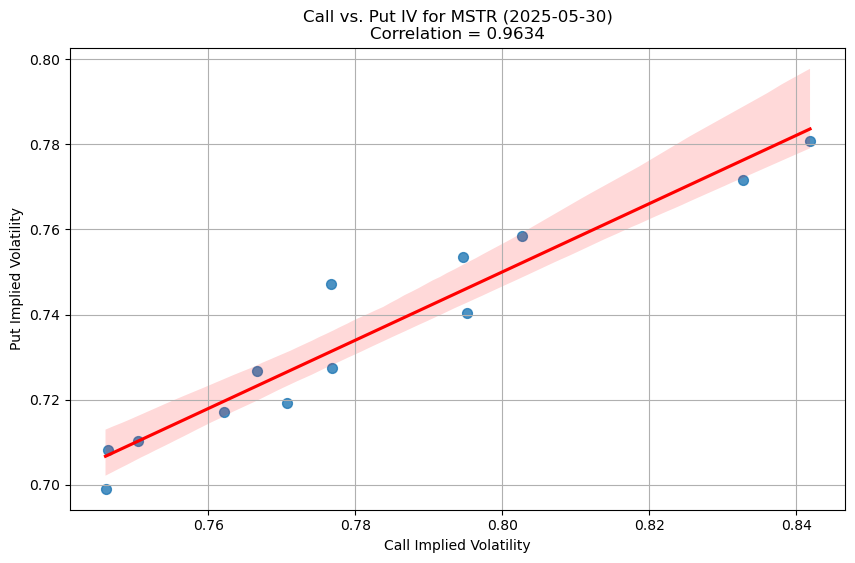

In [55]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Choose stock 
ticker = "MSTR"
stock = yf.Ticker(ticker)
stock_price = stock.history(period="1d")['Close'].iloc[-1]
print(f"Current stock price: {stock_price:.2f}")

# Pick expiration date
exp_date = stock.options[4]  # 0 = nearest expiration
print(f"Using expiration date: {exp_date}")

# Step 3: Get call and put options
opt_chain = stock.option_chain(exp_date)
calls = opt_chain.calls
puts = opt_chain.puts

# Merge calls and puts on a range of strike prices
# Define max percentage above/below stock price
max_percent_above = 1.0  # e.g., 120% of stock price
min_percent_below = 0.80  # e.g., 80% of stock price

# Filter calls
calls = calls[['strike', 'impliedVolatility']].rename(columns={'impliedVolatility': 'call_iv'})
calls = calls[(calls['strike'] <= stock_price * max_percent_above) & (calls['strike'] >= stock_price * min_percent_below)]

# Filter puts
puts = puts[['strike', 'impliedVolatility']].rename(columns={'impliedVolatility': 'put_iv'})
puts = puts[(puts['strike'] <= stock_price * max_percent_above) & (puts['strike'] >= stock_price * min_percent_below)]

# Merged data
merged = pd.merge(calls, puts, on='strike')
merged.dropna(inplace=True)

# Step 5: Calculate correlation
correlation = merged['call_iv'].corr(merged['put_iv'])
print(f"Correlation between Call and Put IV: {correlation:.4f}")

# Step 6: Plot
plt.figure(figsize=(10, 6))
sns.regplot(data=merged, x='call_iv', y='put_iv', scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title(f"Call vs. Put IV for {ticker} ({exp_date})\nCorrelation = {correlation:.4f}")
plt.xlabel('Call Implied Volatility')
plt.ylabel('Put Implied Volatility')
plt.grid(True)
plt.show()


In [56]:
# Plotted data in tabular form
merged

,strike,call_iv,put_iv
0,295.0,0.841859,0.780825
1,300.0,0.832704,0.771670
2,305.0,0.802675,0.758425
3,310.0,0.794619,0.753481
4,315.0,0.776675,0.747195
5,320.0,0.795229,0.740359
6,325.0,0.766634,0.726687
7,330.0,0.776797,0.727420
8,335.0,0.770724,0.719241
9,340.0,0.762087,0.717074


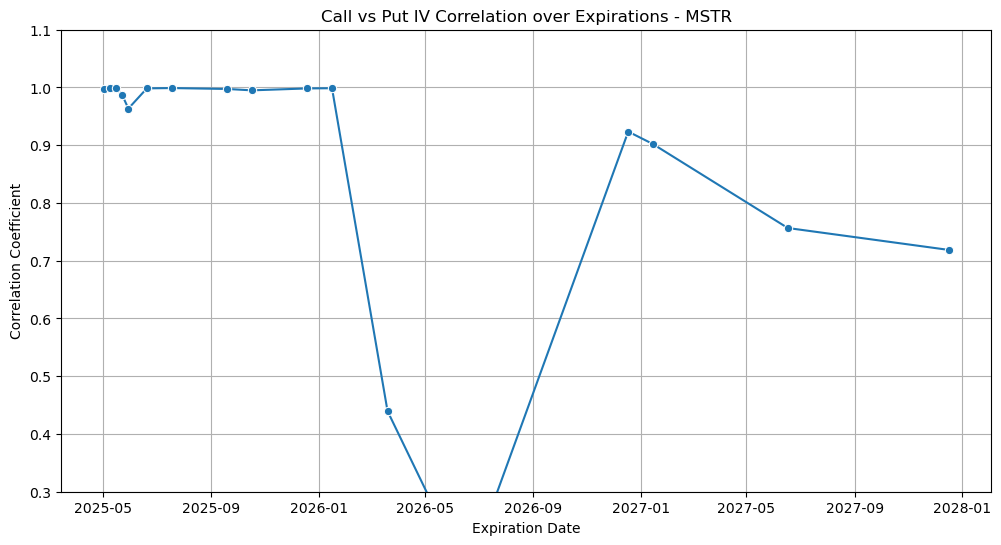

In [57]:
# Hold results
correlations = []

# Iterate over expirations
for exp_date in stock.options:
    try:
        opt_chain = stock.option_chain(exp_date)
        
        # Merge calls and puts on a range of strike prices
        # Define max percentage above/below stock price
        #max_percent_above = 1.0  # e.g., 120% of stock price
        #min_percent_below = 0.80  # e.g., 80% of stock price

        # Filter calls
        calls = opt_chain.calls[['strike', 'impliedVolatility']].rename(columns={'impliedVolatility': 'call_iv'})
        calls = calls[(calls['strike'] <= stock_price * max_percent_above) & (calls['strike'] >= stock_price * min_percent_below)]

        # Filter puts
        puts = opt_chain.puts[['strike', 'impliedVolatility']].rename(columns={'impliedVolatility': 'put_iv'})
        puts = puts[(puts['strike'] <= stock_price * max_percent_above) & (puts['strike'] >= stock_price * min_percent_below)]
        
        merged = pd.merge(calls, puts, on='strike')
        merged.dropna(inplace=True)

        if not merged.empty:
            corr = merged['call_iv'].corr(merged['put_iv'])
            correlations.append({'expiration': exp_date, 'correlation': corr})
    except Exception as e:
        print(f"Failed for expiration {exp_date}: {e}")

# Create DataFrame
corr_df = pd.DataFrame(correlations)
corr_df['expiration'] = pd.to_datetime(corr_df['expiration'])

# Sort
corr_df.sort_values('expiration', inplace=True)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=corr_df, x='expiration', y='correlation', marker='o')
plt.title(f"Call vs Put IV Correlation over Expirations - {ticker}")
plt.xlabel("Expiration Date")
plt.ylabel("Correlation Coefficient")
plt.ylim(0.3, 1.1)
plt.grid(True)
plt.show()

In [58]:
# Show correlation in tabular form
print(corr_df)

   expiration  correlation
0  2025-05-02     0.996531
1  2025-05-09     0.999211
2  2025-05-16     0.999331
3  2025-05-23     0.986974
4  2025-05-30     0.963433
5  2025-06-20     0.998450
6  2025-07-18     0.998975
7  2025-09-19     0.997412
8  2025-10-17     0.995011
9  2025-12-19     0.998352
10 2026-01-16     0.998703
11 2026-03-20     0.439543
12 2026-06-18     0.155181
13 2026-12-18     0.923590
14 2027-01-15     0.902055
15 2027-06-17     0.756651
16 2027-12-17     0.718626
